In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from skopt.space import Real, Integer
from modules.interface import RunModel, RunOptimization
from modules.models import XGBoostTraining
from sklearn.metrics import mean_squared_error

In [4]:
# --- INÍCIO DO SCRIPT DE TESTE ---

# 1. Carregar o Banco de Dados (California Housing)
print("1. Carregando o banco de dados...")
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target)

# 2. Dividir os dados em Conjunto de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- OTIMIZAÇÃO PARA LIGHTGBM ---
print("="*50)
print("INICIANDO OTIMIZAÇÃO PARA LIGHTGBM")
print("="*50)

space_lgbm = [
    Real(name='learning_rate', low = 0.01 , high = 0.9),
    Integer(name='num_leaves', low = 200, high = 700),
    Integer(name='max_depth', low = 200, high = 700),
    Real(name='feature_fraction', low = 0.5 , high = 1),
    Real(name='bagging_fraction', low = 0.7 , high = 1),
    Integer(name='bagging_freq', low = 1, high = 10),
    Real(name='lambda_l1',low = 0.0, high = 1),
    Real(name='lambda_l2',low = 0.5, high = 1)
]

fixed_params_lgbm = {
    'objective': 'mae', 
    'metric': 'mae', 
    'num_iterations ': 300,
    'random_state': 42, 
    'n_jobs': -1, 
    'verbose': -1
}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=10, verbose=False)]}
optimization_kwargs = {'n_initial_points': 5,
                        'n_calls': 10,
                        'initial_point_generator': 'lhs',
                        'random_state': 42,

                       
                       }

# Simplesmente passe 'model_type="lightgbm"'
optimizer_lgbm = RunOptimization()
results=optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=[X_train, X_test, y_train, y_test],
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs

)

optimizer_lgbm.optimizer[0].fit_best_model()

1. Carregando o banco de dados...
INICIANDO OTIMIZAÇÃO PARA LIGHTGBM


In [5]:
print(f"\nMelhor MAE para LightGBM: {results[0].fun:.4f}")
print(f"Melhores parâmetros: {results[0].x}")

print(optimizer_lgbm.optimizer[0].X_test)
print(optimizer_lgbm.optimizer[0].y_test)
print(optimizer_lgbm.optimizer[0].y_test)

print(type(optimizer_lgbm.optimizer[0].X_test))
print(type(optimizer_lgbm.optimizer[0].y_test))
print(type(optimizer_lgbm.optimizer[0].y_pred))


Melhor MAE para LightGBM: 0.2919
Melhores parâmetros: [0.05756085203651178, np.int64(581), np.int64(672), 0.9945106376476827, 0.9688357686840274, np.int64(5), 0.1699046698035288, 0.7061056784233943]
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
20046  1.6812      25.0  4.192201   1.022284      1392.0  3.877437     36.06   
3024   2.5313      30.0  5.039384   1.193493      1565.0  2.679795     35.14   
15663  3.4801      52.0  3.977155   1.185877      1310.0  1.360332     37.80   
20484  5.7376      17.0  6.163636   1.020202      1705.0  3.444444     34.28   
9814   3.7250      34.0  5.492991   1.028037      1063.0  2.483645     36.62   
...       ...       ...       ...        ...         ...       ...       ...   
15362  4.6050      16.0  7.002212   1.066372      1351.0  2.988938     33.36   
16623  2.7266      28.0  6.131915   1.256738      1650.0  2.340426     35.36   
18086  9.2298      25.0  7.237676   0.947183      1585.0  2.790493     37.31   


In [6]:
parameters_run_model = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "metric": ["mae"],
    "num_leaves": 30,
    "max_depth": 7,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "num_boost_round": 1000,
    "early_stopping_rounds": 5,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "force_row_wise": True,
    "verbosity": -1
}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=10, verbose=False)]}

# Simplesmente passe 'model_type="lightgbm"'
lgbm_model = RunModel()
results=lgbm_model.run(
    model_class="lgbm",
    datasets=[X_train, X_test, y_train, y_test],
    params=parameters_run_model,
    calibration_kwargs= calibration_kwargs
)

In [7]:
print(type(lgbm_model.models))
print(type(lgbm_model.models[0]))
print(type(results))
print(type(results[0]))
y_pred=lgbm_model.models[0]

print(type(y_pred))
print(y_pred)

<class 'list'>
<class 'modules.models.LGBMTraining'>
<class 'list'>
<class 'lightgbm.basic.Booster'>
<class 'modules.models.LGBMTraining'>


In [8]:
# --- 1. CARREGAMENTO E PREPARAÇÃO DOS DADOS ---
housing = fetch_california_housing()

# Transforma os dados em um DataFrame do Pandas (tabela com colunas nomeadas)
X = pd.DataFrame(housing.data, columns=housing.feature_names)
# Transforma o alvo (preço) em uma Series do Pandas
y = pd.Series(housing.target)

# Divide os dados: 80% para o modelo aprender (Train) e 20% para prova final (Test)
# random_state=0 garante que a divisão seja sempre a mesma toda vez que rodar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# --- 2. INICIALIZAÇÃO DA SUA CLASSE ---
# Cria o objeto 'test' e já guarda os dados de treino e teste dentro dele
test = XGBoostTraining(X_train, X_test, y_train, y_test)

# --- 3. DEFINIÇÃO DOS HIPERPARÂMETROS ---
# Configurações de "como" o modelo deve aprender
params = {
    'learning_rate': 0.15,      # Tamanho do passo. 0.15 é moderado (nem muito lento, nem muito rápido).
    'max_depth': 8,             # Profundidade da árvore. 8 é relativamente profundo (capta padrões complexos).
    'min_child_weight': 1,      # Controle de overfitting. Define o peso mínimo para criar uma nova folha.
    'subsample': 0.5,           # Usa apenas 50% das linhas aleatórias para criar cada árvore (evita decorar).
    'colsample_bytree': 0.5,    # Usa apenas 50% das colunas (features) aleatórias por árvore.
    'objective': 'reg:squarederror', # Define que é um problema de Regressão (prever números).
    'eval_metric': 'rmse'            # A métrica que o Early Stopping vai olhar para decidir se para ou continua.
}

# --- 4. TREINAMENTO DO MODELO ---
# num_boost_round=1000: O modelo tem permissão para criar até 1000 árvores (limite máximo).
# early_stopping_rounds=100: Se o erro (RMSE) não diminuir por 100 rodadas seguidas, ele para antes das 1000.
# params=params: Passa o dicionário de configurações definido acima.
test.train(params=params, num_boost_round=1000, early_stopping_rounds=100) 

# --- 5. PREVISÃO ---
# Gera as previsões usando os dados de teste (X_test) que já estão salvos na classe.
# Graças ao código da classe, ele usa a 'best_iteration', ignorando as árvores ruins do final.
p = test.predict() 

# --- 6. AVALIAÇÃO VISUAL ---
# Cria uma tabela para comparar lado a lado o Gabarito (Real) vs o Chute (Previsão)
tabela = pd.DataFrame({
    'Valor Real': y_test.values,
    'Previsão' : p,
    'Diferença': y_test.values - p # Quanto o modelo errou (positivo = chutou baixo, negativo = chutou alto)
})

# --- 7. MÉTRICAS FINAIS ---
# Mostra as primeiras 50 linhas para inspeção visual
print(tabela.head(50))

# Calcula o RMSE (Raiz do Erro Quadrático Médio). 
# Quanto menor esse número, melhor o modelo.
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, p))}")




[0]	train-rmse:1.04759	test-rmse:1.04072
[1]	train-rmse:0.97666	test-rmse:0.97571
[2]	train-rmse:0.92078	test-rmse:0.92488
[3]	train-rmse:0.86799	test-rmse:0.88018
[4]	train-rmse:0.79637	test-rmse:0.81575
[5]	train-rmse:0.73442	test-rmse:0.75578
[6]	train-rmse:0.68508	test-rmse:0.71478
[7]	train-rmse:0.64044	test-rmse:0.67240
[8]	train-rmse:0.60824	test-rmse:0.64547
[9]	train-rmse:0.59139	test-rmse:0.63160
[10]	train-rmse:0.57110	test-rmse:0.61669
[11]	train-rmse:0.53971	test-rmse:0.58904
[12]	train-rmse:0.52059	test-rmse:0.57426
[13]	train-rmse:0.50533	test-rmse:0.56380
[14]	train-rmse:0.49380	test-rmse:0.55607
[15]	train-rmse:0.47426	test-rmse:0.53757
[16]	train-rmse:0.46478	test-rmse:0.53230
[17]	train-rmse:0.45966	test-rmse:0.52915
[18]	train-rmse:0.45457	test-rmse:0.52769
[19]	train-rmse:0.44192	test-rmse:0.51680
[20]	train-rmse:0.43583	test-rmse:0.51355
[21]	train-rmse:0.43028	test-rmse:0.51096
[22]	train-rmse:0.41783	test-rmse:0.50083
[23]	train-rmse:0.41354	test-rmse:0.49861
[2

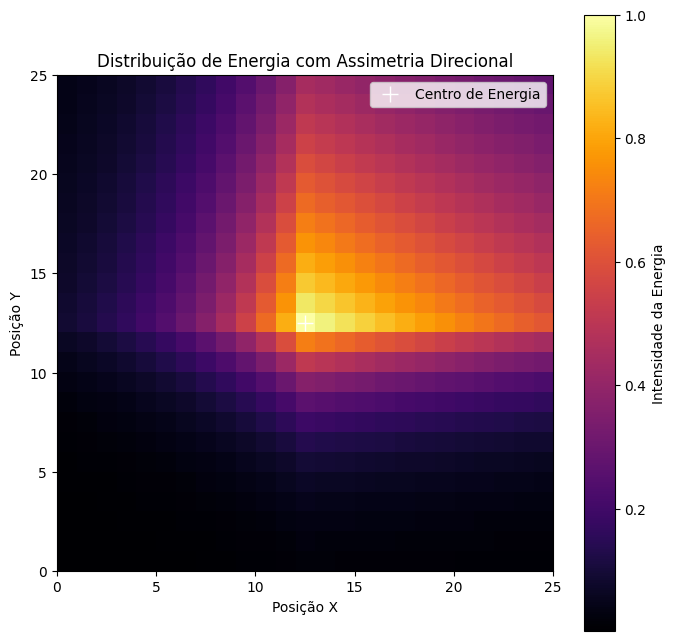

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensão do grid
N = 25
data = np.zeros((N, N))

# Definir célula central (meio do grid)
cx, cy = N//2, N//2

# --- CONTROLE DA ASSIMETRIA ---
# Altere estes valores para controlar a rapidez com que a energia decai em cada direção.
# Valores maiores = decaimento mais lento (energia se espalha mais).
# Valores menores = decaimento mais rápido (energia mais concentrada).
decay_x_positivo = 25.0 # Direita
decay_x_negativo = 5.0  # Esquerda
decay_y_positivo = 15.0 # Cima
decay_y_negativo = 3.0  # Baixo


# Irradiação de energia
for i in range(N):
    for j in range(N):
        # CORREÇÃO: dx é a distância horizontal (colunas, j) e dy é a vertical (linhas, i)
        dx_abs = abs(j - cx)
        dy_abs = abs(i - cy)

        # Determina o fator de decaimento em X com base na posição horizontal (j)
        if j >= cx:
            decay_x = decay_x_positivo
        else:
            decay_x = decay_x_negativo

        # Determina o fator de decaimento em Y com base na posição vertical (i)
        if i >= cy:
            decay_y = decay_y_positivo
        else:
            decay_y = decay_y_negativo
            
        # Calcula a energia com os decaimentos direcionais corretos
        # Adicionamos uma pequena constante (1e-9) para evitar divisão por zero se o decaimento for 0
        energia = np.exp(-(dx_abs / (decay_x + 1e-9) + dy_abs / (decay_y + 1e-9)))
        data[i, j] = energia

# Plotar o grid como mapa de calor
plt.figure(figsize=(8, 8))
plt.imshow(data, cmap="inferno", origin="lower", extent=[0, N, 0, N])
plt.colorbar(label="Intensidade da Energia")
plt.title("Distribuição de Energia com Assimetria Direcional")
plt.xlabel("Posição X")
plt.ylabel("Posição Y")

# Adicionar uma marcação no centro
plt.plot(cx + 0.5, cy + 0.5, 'w+', markersize=12, label='Centro de Energia')
plt.legend()
plt.grid(False)
plt.show()

